In [5]:
# Load MNIST dataset
# https://en.wikipedia.org/wiki/MNIST_database

from keras.datasets.mnist import load_data

(train_X, train_y), (test_X, test_y) = load_data()

In [6]:
print('Train', train_X.shape, train_y.shape)
print('Test', test_X.shape, test_y.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


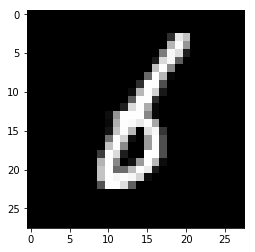

In [7]:
from matplotlib import pyplot

# plot raw pixel data
pyplot.imshow(train_X[256], cmap='gray')

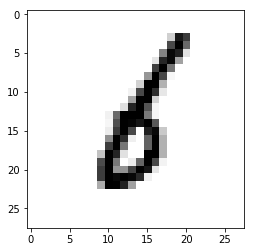

In [8]:
pyplot.imshow(train_X[256], cmap='gray_r')